# Quantum Approximate Optimization Algorithm (QAOA): MaxCut Problem

This notebook demonstrates the QAOA algorithm using Classiq. It covers the Max-Cut problem as an example of a combinatorial optimization problem, showcasing how QAOA can be applied to graph-based optimization tasks [[1](#QAOA)].

## Introduction

### The Max-Cut Problem

Given an undirected graph $G = (V, E)$, the goal is to partition the vertices into two sets **to maximize the number of edges between the sets**. In this context, an edge between is "cut" **if its endpoints belong to different sets**. The standard formulation is:

**Input:**  
- $G = (V, E)$: A graph with vertices $V$ and edges $E$.

**Output:**  
- A partition $S, \bar{S}$ that maximizes the cut value:
$$
f_{obj}(x)=\max_{S \subset V} \sum_{(i,j) \in E} \left(1 - \delta_{s_i, s_j}\right)
$$
where $s_i$ indicates the subset assignment for vertex $i$, and $\delta_{s_i, s_j}$ is the Kronecker delta function.

The Max-Cut problem is known to be $\mathsf{NP}$-complete.

**Note:** A weighted version exists, where each edge has a weight $w_{ij}$, and the goal is to maximize the weighted sum of cut edges.


### Set a Specific Problem Instance to Optimize

We choose a small toy Max-Cut instance using a **5-node graph**:
- **Vertices:** $V = \{0,1,2,3,4\}$
- **Edges:** $E = \{(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)\}$

#### Optimal Max-Cut Solutions
Several partitions achieve the maximum cut value (cutting 5 out of 6 edges). For example:

**Option 1:**  
- **Set 1:** $\{0,2,3\}$
- **Set 2:** $\{1,4\}$

**Option 2:**  
- **Set 1:** $\{2,3\}$
- **Set 2:** $\{0,1,4\}$

Both options represent optimal solutions for this graph, showcasing the non-uniqueness of the optimal partition in a non-trivial Max-Cut instance.


## Algorithm Description

In this problem, we apply quantum transformations to optimize the Max-Cut objective function. A quantum state $|x\rangle$ represents a candidate partition of the graph. The QAOA algorithm comprises two key layers:

1. **Objective Phase (Analog):**  
   A phase rotation in the $Z$-direction is applied based on the objective function:
   $$
   |x\rangle \xrightarrow{U_{\text{o}}(\theta)} e^{i\gamma f_{\text{obj}}(x)} |x\rangle,
   $$
   which encodes the cost associated with a given partition.

2. **Mixing Operator (Digital):**  
   An $X$-rotation is applied to all qubits to explore the solution space:
   $$
   U_B(\beta) = e^{-i\beta H_B}, \quad \text{with } H_B = \sum_i X_i.
   $$
   This promotes transitions between different partitions.

By alternating these layers, the QAOA ansatz iteratively refines the quantum state toward a partition that maximizes the number of cut edges.


## Algorithm Implementation using Classiq

The implementation follows a modular design:

- **Cost Function:**  
  The function `maxcut_cost` computes the normalized negative number of cut edges for a given partition.

- **Cost Layer:**  
  The quantum function `maxcut_cost_layer` uses the `phase` statement to encode this cost into the quantum state, with the parameter $\gamma$ controlling the phase rotation.

- **Mixer Layer:**  
  The function `mixer_layer` applies uniform $RX$ rotations (with parameter $\beta$) to all qubits.

- **QAOA Ansatz:**  
  The overall circuit is constructed by first preparing a uniform superposition (via a Hadamard transform) and then alternating the cost and mixer layers for a specified number of layers.


### Define the MaxCut problem

The implementation we are following is general, but to demonstrate it properly, you will use the specific problem described above. We begin by declaring the nodes and edges of the graph:

In [1]:
from classiq import *

graph_nodes = [0, 1, 2, 3, 4]
graph_edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

Visualizing the above-defined graph:

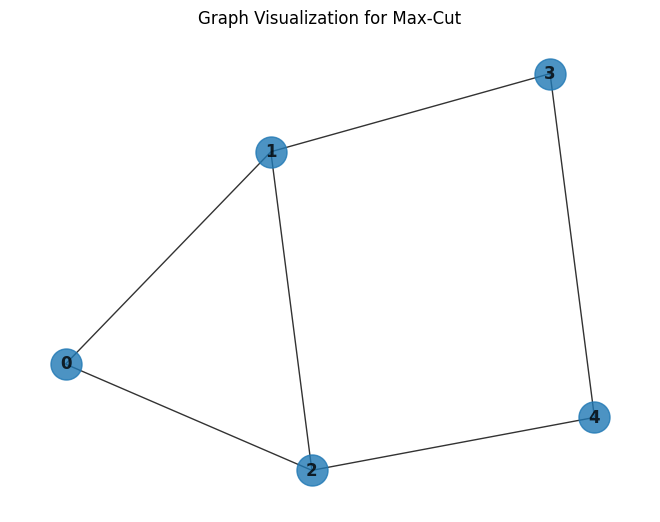

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph instance
G = nx.Graph()
G.add_nodes_from(graph_nodes)
G.add_edges_from(graph_edges)

# Use a layout for better visualization
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, font_weight="bold")
plt.title("Graph Visualization for Max-Cut")
plt.show()

### Algorithms Building Blocks

#### The Cost Layer

The function `maxcut_cost` computes the normalized, negative cost of a partition represented by the quantum state `v`. This means that instead of using the conventional objective function:

$$
f(x) = \sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right),
$$

we use in this implementation:

$$
\text{maxcut\_cost}(x) = -\frac{1}{|E|}\sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right).
$$

This modification serves two purposes:

- **Normalization:** Dividing by the number of edges $|E|$ scales the cost to a consistent range, making it easier to compare across different graphs.
- **Negation for Minimization:** By negating the sum, we can employ minimization algorithms to effectively maximize the number of cut edges.

An inner function, `edge_cut`, determines whether an edge is "cut" (i.e., its endpoints are in different sets), returning 1 if the edge is cut and 0 otherwise.

*Note:* This function is not decorated with `@qfunc` because it is used as an operator within another quantum function. TODO: Make sure

Below is the implementation:


In [3]:
def maxcut_cost(v: QArray[QBit] | list[int]):
    def edge_cut(n1_bit, n2_bit):
        return n1_bit * (1 - n2_bit) + n2_bit * (1 - n1_bit)

    return -sum(edge_cut(v[node1], v[node2]) for (node1, node2) in graph_edges) / len(
        graph_edges
    )

The following quantum function, `maxcut_cost_layer`, uses the `phase` operation to encode the computed cost into the phase of the quantum state. The parameter `gamma` controls the strength of this phase rotation.

In [4]:
@qfunc
def maxcut_cost_layer(gamma: CReal, v: QArray[QBit]):
    phase(-maxcut_cost(v), gamma)

#### The Mixer Layer

The next main building block is the **mixer layer**. This layer is responsible for exploring the solution space by applying RX rotations to all qubits. By "mixing" the amplitudes between different basis states, the mixer layer prevents the algorithm from getting stuck in local minima and allows the quantum state to transition between different candidate solutions.

Below, the `mixer_layer` is implemented as a quantum function that applies an RX rotation (parameterized by β) to each qubit in the array.

In [5]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(beta, q), qba)

#### The QAOA Ansatz

The overall QAOA ansatz alternates between two layers for a specified number of iterations:
- The **cost layer** encodes the problem’s objective into the quantum state.
- The **mixer layer** promotes transitions between different candidate solutions.

The ansatz operates on a uniform superposition state (prepared in the `main` function) by repeatedly applying these two layers.

In [6]:
@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray[QBit]],
    num_layers: CInt,
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray[QBit],
):
    repeat(
        num_layers,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

## Assemble to the full QAOA algorithm

As in vanilla QAOA, the quantum program first applies a `hadamard_transform()` to prepare the qubits in a uniform superposition. After this initial state preparation, the circuit sequentially applies the cost and mixer layers, each with their own parameters that are updated by the classical optimization loop as we will show in the next section.

In [7]:
NUM_LAYERS = 4


@qfunc
def main(
    params: CArray[CReal, NUM_LAYERS * 2],
    v: Output[QArray[QBit, len(graph_nodes)]],
):
    allocate(v.size, v)
    hadamard_transform(v)  # here or aside?
    qaoa_ansatz(
        maxcut_cost_layer,
        NUM_LAYERS,
        params[0:NUM_LAYERS],
        params[NUM_LAYERS : 2 * NUM_LAYERS],
        v,
    )

Having defined the `main` function, now you can create the model, synthesize it, and display the resulting quantum program. Note that this synthesized program is not yet executable since we haven't specified any parameter set.

In [8]:
from classiq.interface.executor.execution_preferences import ExecutionPreferences

NUM_SHOTS = 1000  # Per execution

qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)
qprog = synthesize(qmod)
# show(qprog)

## Classical Optimization

We have constructed a modular, parameterized QAOA circuit for the Max-Cut problem. The circuit accepts a parameter array of size $NUM\_LAYERS \times 2$, with the first half corresponding to the cost layer parameters (gammas) and the second half to the mixer layer parameters (betas).

We execute the circuit using an `ExecutionSession`, which is configured to sample a fixed number of shots ($NUM\_SHOTS$) per evaluation. The function `ExecutionSession.estimate_cost` computes the cost for a given parameter set using the `maxcut_cost` function embedded in our cost layer.

Our classical optimization uses `scipy.optimize.minimize` with the COBYLA method. By minimizing our (negative) cost function, we are effectively maximizing the number of cut edges.

Below is the code that implements the classical optimization loop.

We define the objective function `objective_func` to evaluate the current parameters. This function takes a parameter vector, converts it to a list, and then calls `es.estimate_cost` with our cost function. The optimizer minimizes this function. Additionally, we initialize two lists—`cost_trace` and `params_history`—to record the cost and parameter values at each iteration for later analysis or debugging.

*Note:* `cost_func` is defined later as a lambda function that computes the cost using `maxcut_cost(state["v"])`.

In [9]:
cost_trace = []
params_history = []


def objective_func(params):
    cost_estimation = es.estimate_cost(cost_func, {"params": params.tolist()})
    cost_trace.append(cost_estimation)
    params_history.append(params.copy())
    return cost_estimation

The following code creates an execution session, initializes the parameters, runs the COBYLA optimizer to find the best parameters, and finally samples the circuit with the optimized parameters.

In [10]:
import numpy as np
import scipy
from tqdm import tqdm

from classiq.execution import ExecutionSession

NUM_SHOTS = 1000
MAX_ITERATIONS = 60

# To Ask Or, scale the initial parameters by pi? (not really effecting)
initial_params = np.concatenate(
    (np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS))
)  # * np.pi


es = ExecutionSession(qprog)

# Define the cost function used in the quantum circuit
cost_func = lambda state: maxcut_cost(state["v"])

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)

    optimization_results = scipy.optimize.minimize(
        fun=objective_func,
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

# Sample the circuit using the optimized parameters
res = es.sample({"params": optimization_results.x.tolist()})
es.close()

print(f"Optimized parameters: {optimization_results.x.tolist()}")

Optimization Progress: 61it [01:23,  1.37s/it]                                                      


Optimized parameters: [1.3689630105052923, -0.2555681634101383, 0.7623287713976867, 0.9806308539579661, 1.1030292742865058, 2.0160233138648525, -0.4576955992567988, -0.38086246036558374]


Plotting the convergence graph: 

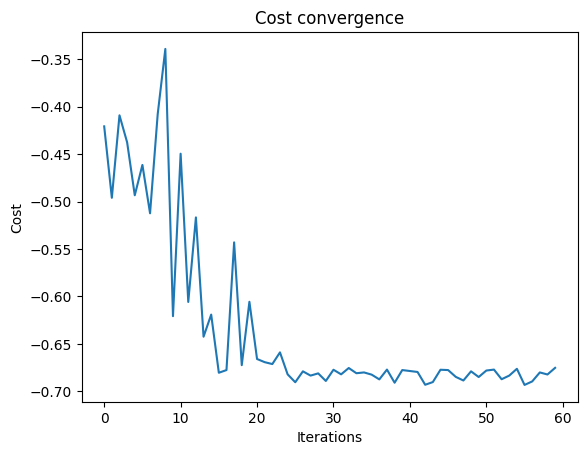

In [11]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

## Displaying and Discussing the Results

After optimization, we print the optimized parameters and display the measurement outcomes. Each outcome is a bitstring representing a candidate partition, with its probability (the fraction of shots) and its cost (computed by `maxcut_cost`). For example, a cost of $-0.833$ indicates that 5 out of 6 edges are cut, which is optimal for this instance ($5/6 \approx 0.833$).

Below is the code that prints the resulting solutions according to the probability:

In [12]:
print(f"Optimized parameters: {optimization_results.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: maxcut_cost(pc.state["v"]))
for sampled in sorted_counts:
    solution = sampled.state["v"]
    probability = sampled.shots / NUM_SHOTS
    cost_value = maxcut_cost(sampled.state["v"])
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [1.3689630105052923, -0.2555681634101383, 0.7623287713976867, 0.9806308539579661, 1.1030292742865058, 2.0160233138648525, -0.4576955992567988, -0.38086246036558374]
solution=[0, 0, 1, 1, 0] probability=0.111 cost=-0.833
solution=[1, 0, 1, 1, 0] probability=0.102 cost=-0.833
solution=[1, 1, 0, 0, 1] probability=0.098 cost=-0.833
solution=[0, 1, 0, 0, 1] probability=0.090 cost=-0.833
solution=[1, 0, 0, 1, 1] probability=0.074 cost=-0.667
solution=[1, 0, 0, 1, 0] probability=0.054 cost=-0.667
solution=[0, 1, 1, 0, 0] probability=0.049 cost=-0.667
solution=[1, 0, 0, 0, 1] probability=0.042 cost=-0.667
solution=[0, 1, 1, 1, 0] probability=0.041 cost=-0.667
solution=[0, 1, 1, 0, 1] probability=0.038 cost=-0.667
solution=[0, 1, 0, 1, 1] probability=0.031 cost=-0.500
solution=[0, 0, 1, 1, 1] probability=0.029 cost=-0.500
solution=[1, 0, 1, 0, 1] probability=0.029 cost=-0.500
solution=[1, 1, 0, 1, 0] probability=0.029 cost=-0.500
solution=[0, 0, 1, 0, 1] probability=0.025 

## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)

Questions for Or:

1. with as in es -  V
2. lambda usage in es
3. How much do we decompose the algorithm and explain it??

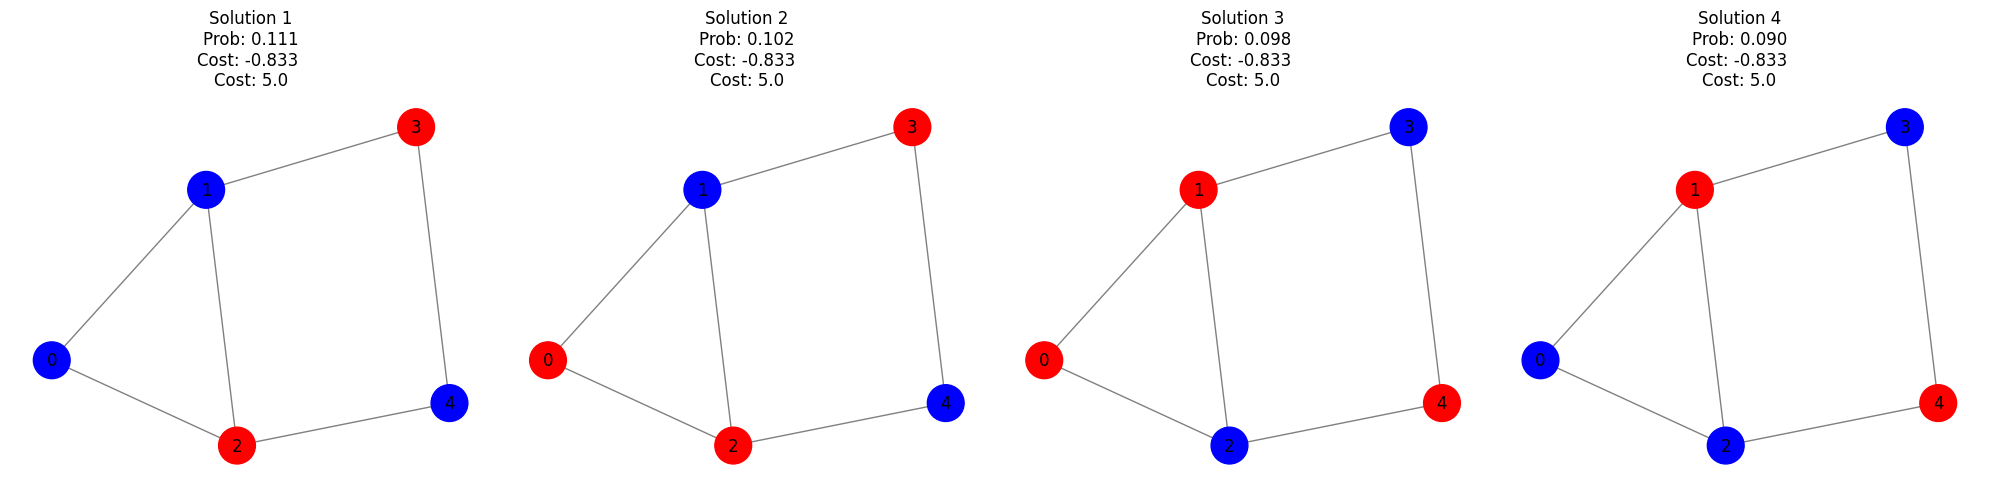

In [18]:
# Optional Addition:

# --- Collect the best solutions from the sampling results ---

# Determine the best (minimal) cost value among all sampled outcomes
best_cost = min(maxcut_cost(pc.state["v"]) for pc in res.parsed_counts)
tolerance = 1e-3  # Set a small tolerance for floating-point comparisons

# Filter out only those outcomes that achieve the best cost within the tolerance
best_outcomes = [
    pc
    for pc in res.parsed_counts
    if abs(maxcut_cost(pc.state["v"]) - best_cost) < tolerance
]

# Optionally, sort the best outcomes by probability (descending)
best_outcomes = sorted(best_outcomes, key=lambda pc: pc.shots / NUM_SHOTS, reverse=True)

# --- Plot the optimal solutions ---

# Create subplots: one for each optimal solution
num_plots = len(best_outcomes)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Ensure axes are iterable even if there's only one subplot
if num_plots == 1:
    axes = [axes]

# Plot each optimal solution
for i, pc in enumerate(best_outcomes):
    solution = pc.state["v"]
    probability = pc.shots / NUM_SHOTS
    cost_value = maxcut_cost(pc.state["v"])
    num_cuts = abs(cost_value * G.size())

    # Color nodes: red for 1, blue for 0
    node_colors = ["red" if bit == 1 else "blue" for bit in solution]

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color="gray",
        ax=axes[i],
        node_size=700,
    )
    axes[i].set_title(
        f"Solution {i+1}\nProb: {probability:.3f}\nCost: {cost_value:.3f} \nCost: {num_cuts:}"
    )

plt.tight_layout()
plt.show()